## DAS event extraction demo

Provided by [Bin Luo](mailto:luob@sustech.edu.cn) 

This notebook demo provides an example of cutting specified windows from continuous DAS data.

The PoroTomo DAS data used in this notebook was accessed through the Geothermal Data Repository (https://gdr.openei.org/submissions/980). The earthquake signal was reported by Wang et al. (2018).

Wang, H. F., X. Zeng, D. E. Miller, D. Fratta, K. L. Feigl, C. H. Thurber, and R. J. Mellors, 2018, Ground motion response to an ML 4.3 earthquake using co-located distributed acoustic sensing and seismometer arrays: Geophysical Journal International, 213, 2020–2036, doi: https://doi.org/10.1093/gji/ggy102.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import signal
from DasTools import DasPrep as dp

import glob
import os

In [2]:
def read_das_data(filename):
    data = dp.read_das(filename)
    metadata = dp.read_das(filename, metadata=True)
    return data, metadata['dt'], metadata['nt']

def get_das_file_time(das_filename, das_name_format):
    return datetime.datetime.strptime(das_filename, das_name_format)

def get_ev_id_in_das_window(event_time_arr, start_time, end_time):
    return np.where((event_time_arr > start_time) & (event_time_arr < end_time))

def get_time_step(start, end, dt):
    return int((start - end).total_seconds() / dt + 1)

def extract_das_data(das_file, das_name_format, ev_time, dt_before, dt_after, save_file_name_prefix, 
                     overwrite=False, verbose=False):
    
    das_file_time = np.array([get_das_file_time(das_file[i], das_name_format) for i in range(len(das_file))])
    
    ev_id_in_das_win = get_ev_id_in_das_window(ev_time, das_file_time.min(), das_file_time.max())
    ev_time_in_das_win = ev_time[ev_id_in_das_win]
    
    ev_time_before = ev_time_in_das_win - datetime.timedelta(seconds=dt_before)
    ev_time_after  = ev_time_in_das_win + datetime.timedelta(seconds=dt_after)

    for iev in range(len(ev_id_in_das_win[0])):

        savename = save_file_name_prefix + str(ev_id_in_das_win[0][iev]) + '.npz'
        
        if verbose: print(savename)

        if not (os.path.exists(savename) and not overwrite):

            ins_start = np.searchsorted(das_file_time, ev_time_before[iev]) - 1
            ins_end = np.searchsorted(das_file_time, ev_time_after[iev])

            das_file_time_select = das_file_time[ins_start:ins_end]
            das_file_select = das_file[ins_start:ins_end]

            ev_t0 = ev_time_before[iev]
            ev_t1 = ev_time_after[iev]

            data = []
            for i in range(len(das_file_select)):

                datatmp, dt, nt = read_das_data(das_file_select[i])
                istart, iend = 0, np.copy(nt)

                das_t0 = das_file_time_select[i]
                das_t1 = das_t0 + datetime.timedelta(seconds=dt*nt)

                if ev_t0 > das_t0:
                    istart = get_time_step(ev_t0, das_t0, dt)

                if ev_t1 < das_t1:
                    iend = get_time_step(ev_t1, das_t0, dt)

                data.append(datatmp[:, istart:iend])

            data = np.concatenate(data, axis=1)
            if (data.size > 0):
                np.savez(savename, data=data.astype('float32'), 
                         dt=dt,
                         event_files=das_file_select, 
                         event_time=ev_time_in_das_win[iev], 
                         pre_time=ev_time_before[iev], 
                         post_time=ev_time_after[iev])

### Read DAS file names, and define the naming convention

### Four contiguous DAS files around the arrival time of the earthquake signal were downloaded

In [4]:
flist = glob.glob('./data/PoroTomo_iDAS16043_160321*')
flist.sort()
flist

['./data/PoroTomo_iDAS16043_160321073721.sgy',
 './data/PoroTomo_iDAS16043_160321073751.sgy',
 './data/PoroTomo_iDAS16043_160321073821.sgy',
 './data/PoroTomo_iDAS16043_160321073851.sgy']

In [5]:
das_name_format = './data/PoroTomo_iDAS16043_%y%m%d%H%M%S.sgy'

### Define a list of desired event times (can be loaded from catalog files)

In [7]:
event_time = np.array([datetime.datetime(2016,3,21,7,37,30)])

In [8]:
%%time

dt_before, dt_after = 5, 70

save_dir = './data_cut/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_file_name_prefix = save_dir + 'PoroTomo_cut_'

extract_das_data(flist, das_name_format, event_time, dt_before, dt_after, 
                 save_file_name_prefix, overwrite=True, verbose=True)

./data_cut/PoroTomo_cut_0.npz
CPU times: user 7.94 s, sys: 14.5 s, total: 22.5 s
Wall time: 31 s


In [9]:
dataz = np.load('./data_cut/PoroTomo_cut_0.npz', allow_pickle=True)

In [10]:
for key in dataz.keys():
    print(key, ':', dataz[key])

data : [[-7.9173241e-03 -4.9340734e-03  2.0300713e-03 ...  4.2056240e-04
   2.7960269e-03  2.8437211e-03]
 [-5.0226292e-03 -5.1133698e-03  2.3492277e-04 ... -1.6412137e-03
   1.9550240e-03  4.8043570e-03]
 [-4.7516678e-03 -5.7947007e-03 -2.0280113e-03 ... -3.0785862e-03
   1.0509782e-03  4.9242117e-03]
 ...
 [ 6.2208509e-01  6.8921596e-01  5.9280932e-01 ... -1.8984888e-01
  -4.9706516e-01 -3.3576852e-01]
 [ 5.4622489e-01  5.0700057e-01  3.9913699e-01 ... -1.9231784e-01
  -7.8454131e-01 -7.0108134e-01]
 [ 5.0292182e-01  4.5582622e-01  3.4606379e-01 ... -4.2229384e-02
  -1.0196520e+00 -1.1066713e+00]]
dt : 0.001
event_files : ['./data/PoroTomo_iDAS16043_160321073721.sgy'
 './data/PoroTomo_iDAS16043_160321073751.sgy'
 './data/PoroTomo_iDAS16043_160321073821.sgy']
event_time : 2016-03-21 07:37:30
pre_time : 2016-03-21 07:37:25
post_time : 2016-03-21 07:38:40


In [11]:
print(dataz['data'].shape)

(8721, 75000)


In [12]:
%%time
M = 10
data1 = signal.decimate(dataz['data'], M, axis=1)
data1 = dp.das_preprocess(data1)

CPU times: user 57.8 s, sys: 55.1 s, total: 1min 52s
Wall time: 2min 30s


In [13]:
print(data1.shape)

(8721, 7500)


### Plot signals and spectra

<IPython.core.display.Javascript object>


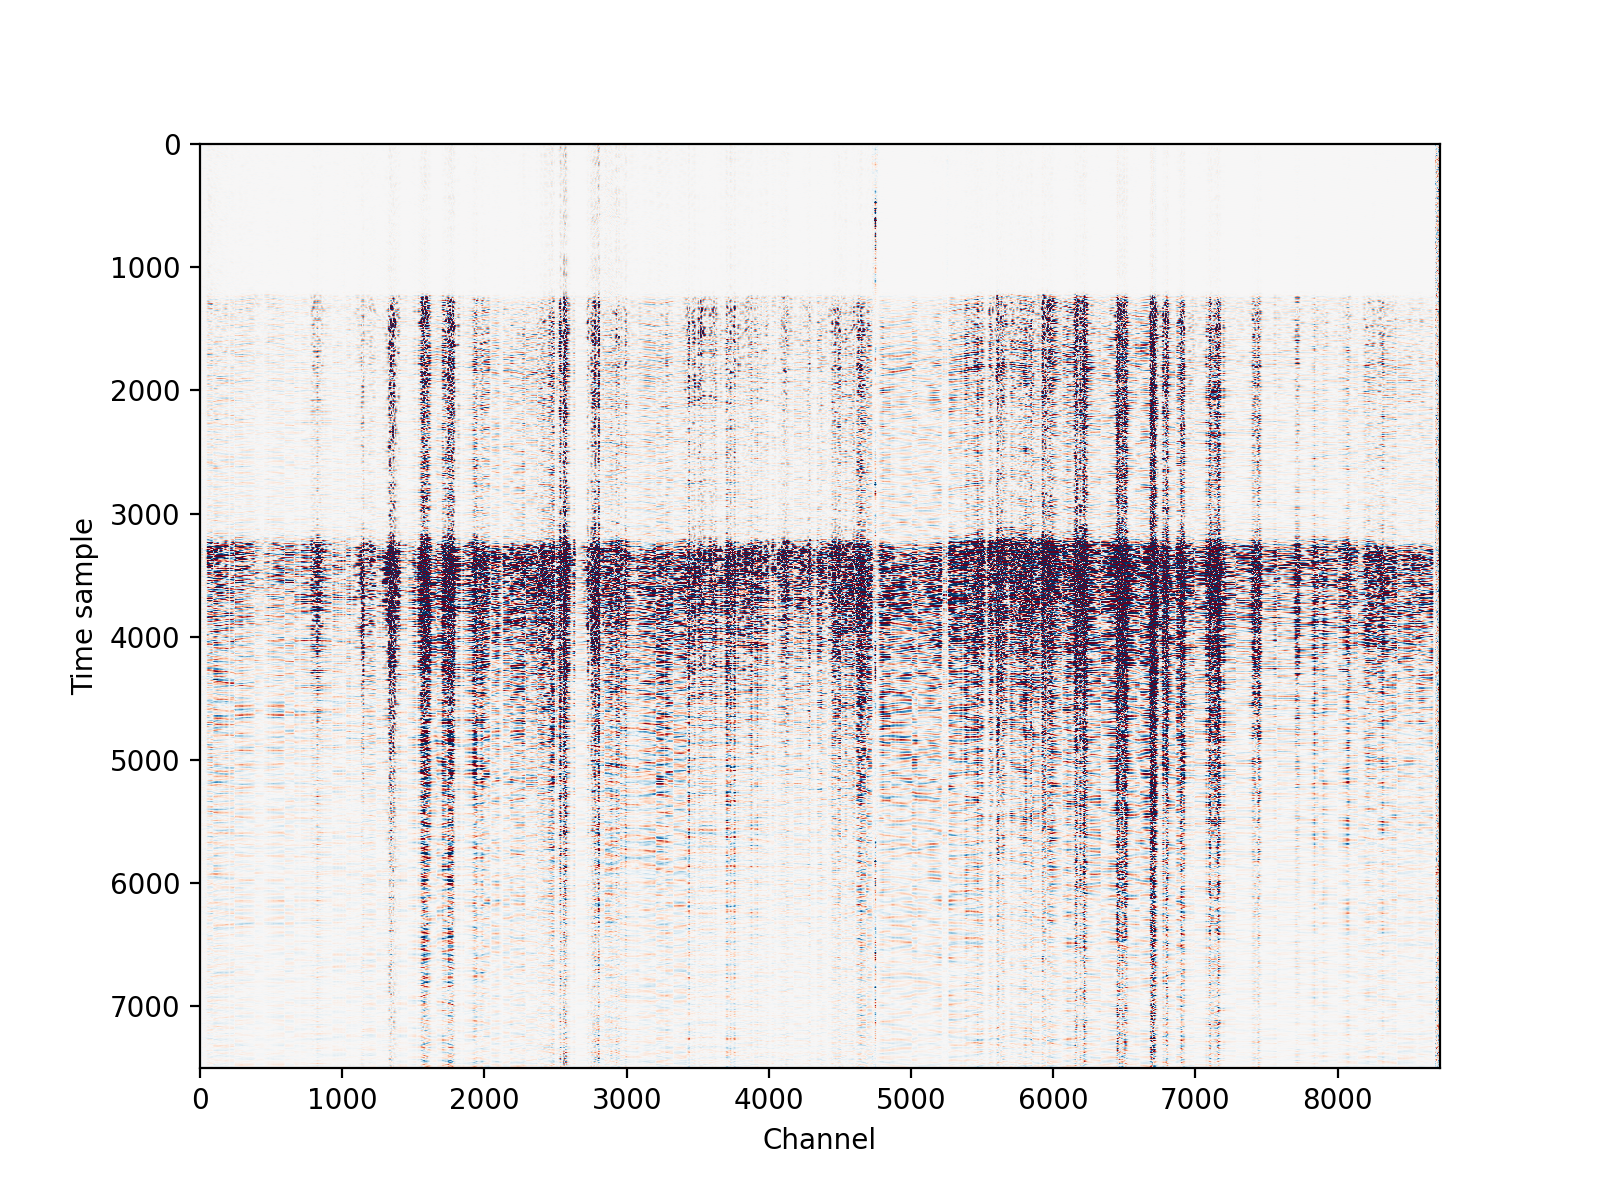

In [15]:
%matplotlib notebook
plt.figure(figsize=[8,6])

data_plot = data1
clim = data_plot.std() / 1
plt.imshow(data_plot[:,:].T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim)

plt.xlabel('Channel')
plt.ylabel('Time sample')
plt.show()

<IPython.core.display.Javascript object>


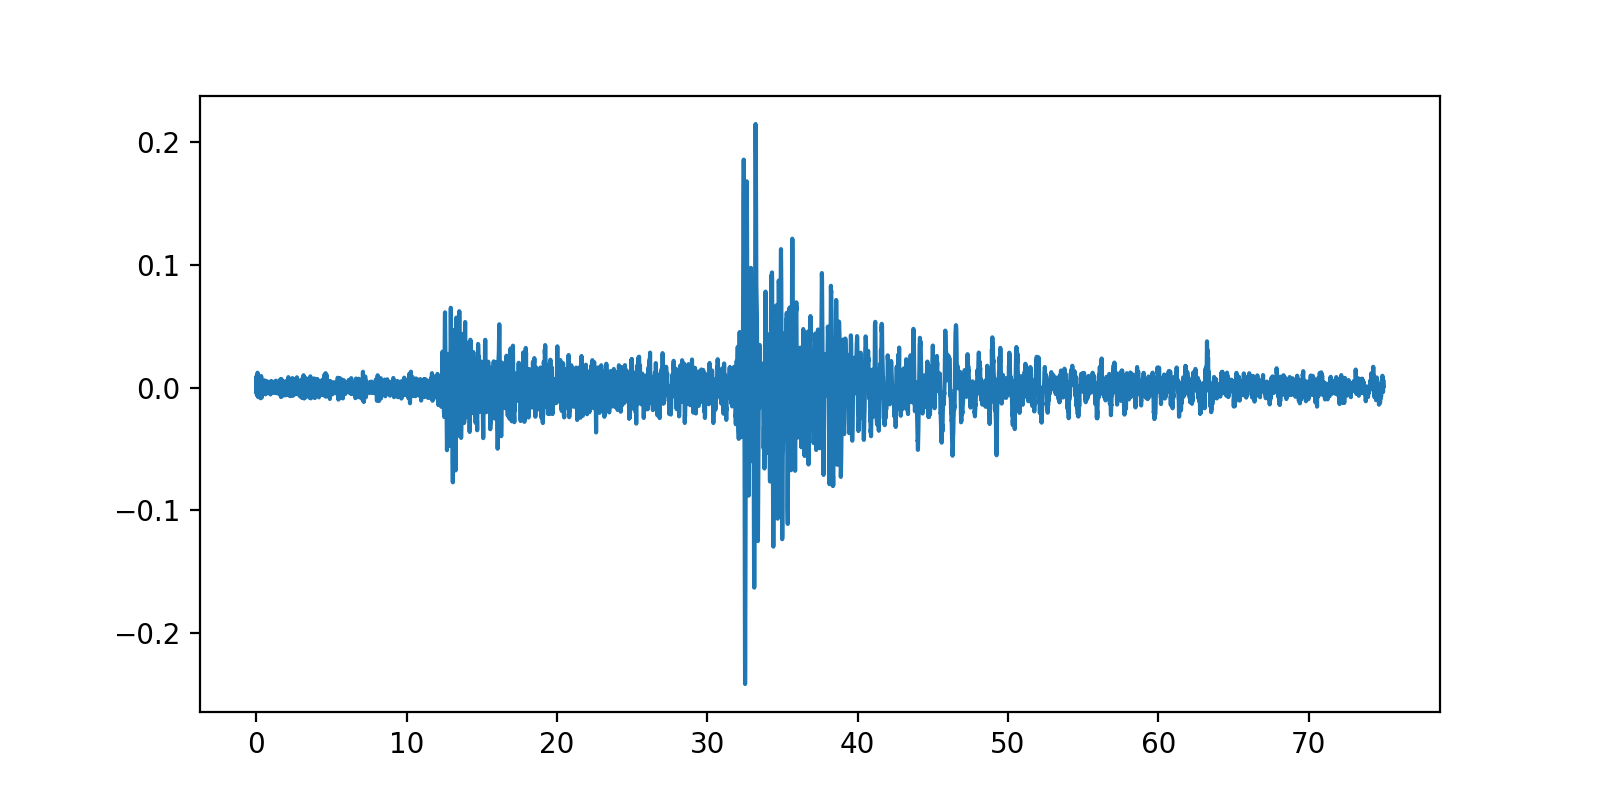

In [16]:
plt.figure(figsize=[8,4])

taxis = np.arange(data1.shape[1]) * dataz['dt'] * M
plt.plot(taxis, data_plot[346,:])

<IPython.core.display.Javascript object>


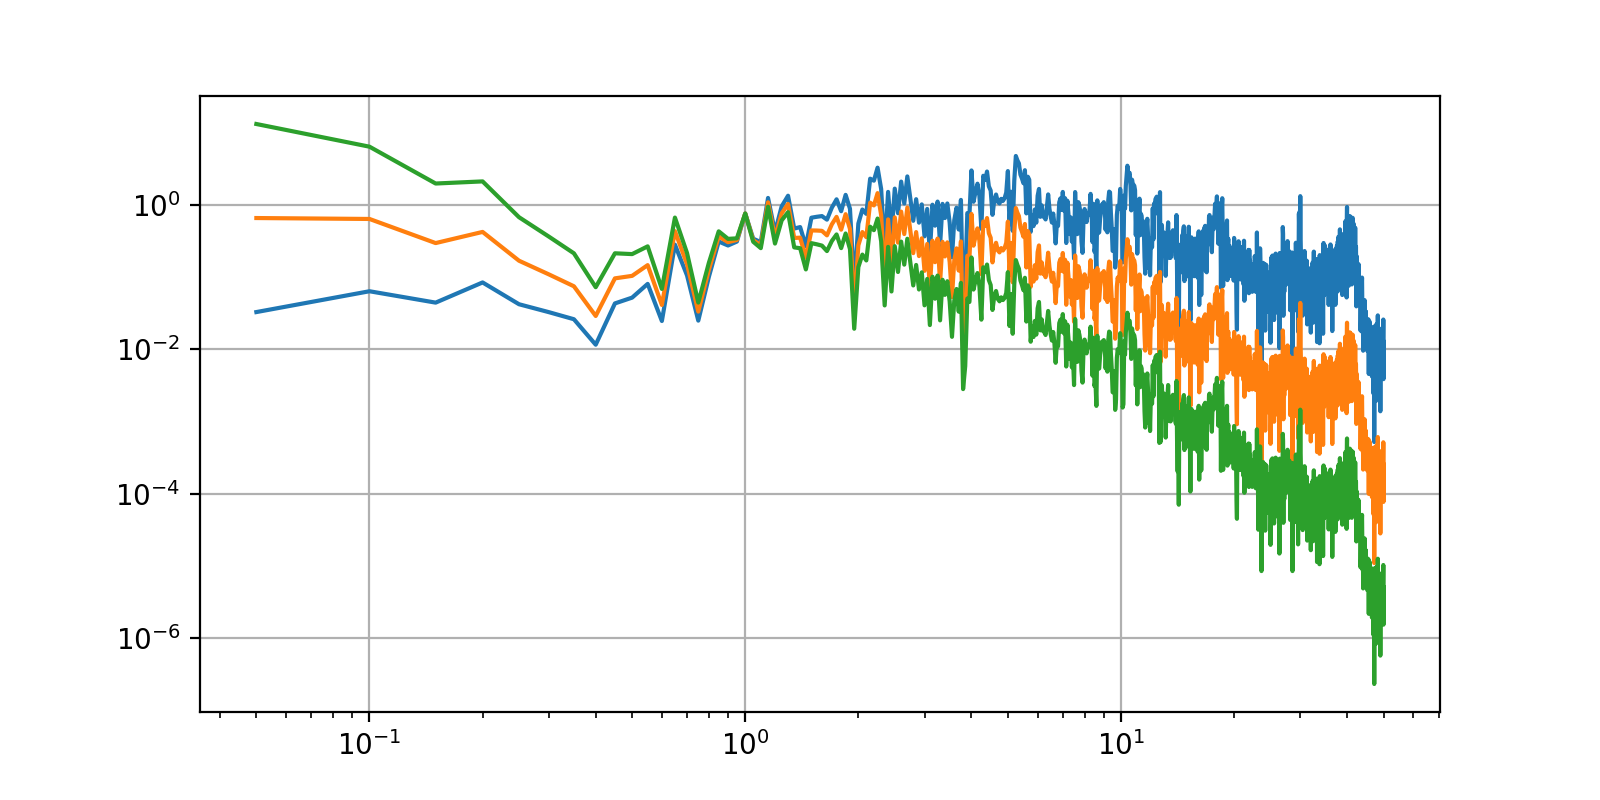

In [19]:
trace = data1[346,1000:3000]
spec = np.fft.rfft(trace)
faxis = np.fft.rfftfreq(trace.shape[0], dataz['dt'] * M)

plt.figure(figsize=[8,4])

plt.loglog(faxis[1:], abs(spec)[1:])
plt.loglog(faxis[1:], abs(spec)[1:]/faxis[1:])
plt.loglog(faxis[1:], abs(spec)[1:]/faxis[1:]/faxis[1:])
plt.grid()

<IPython.core.display.Javascript object>


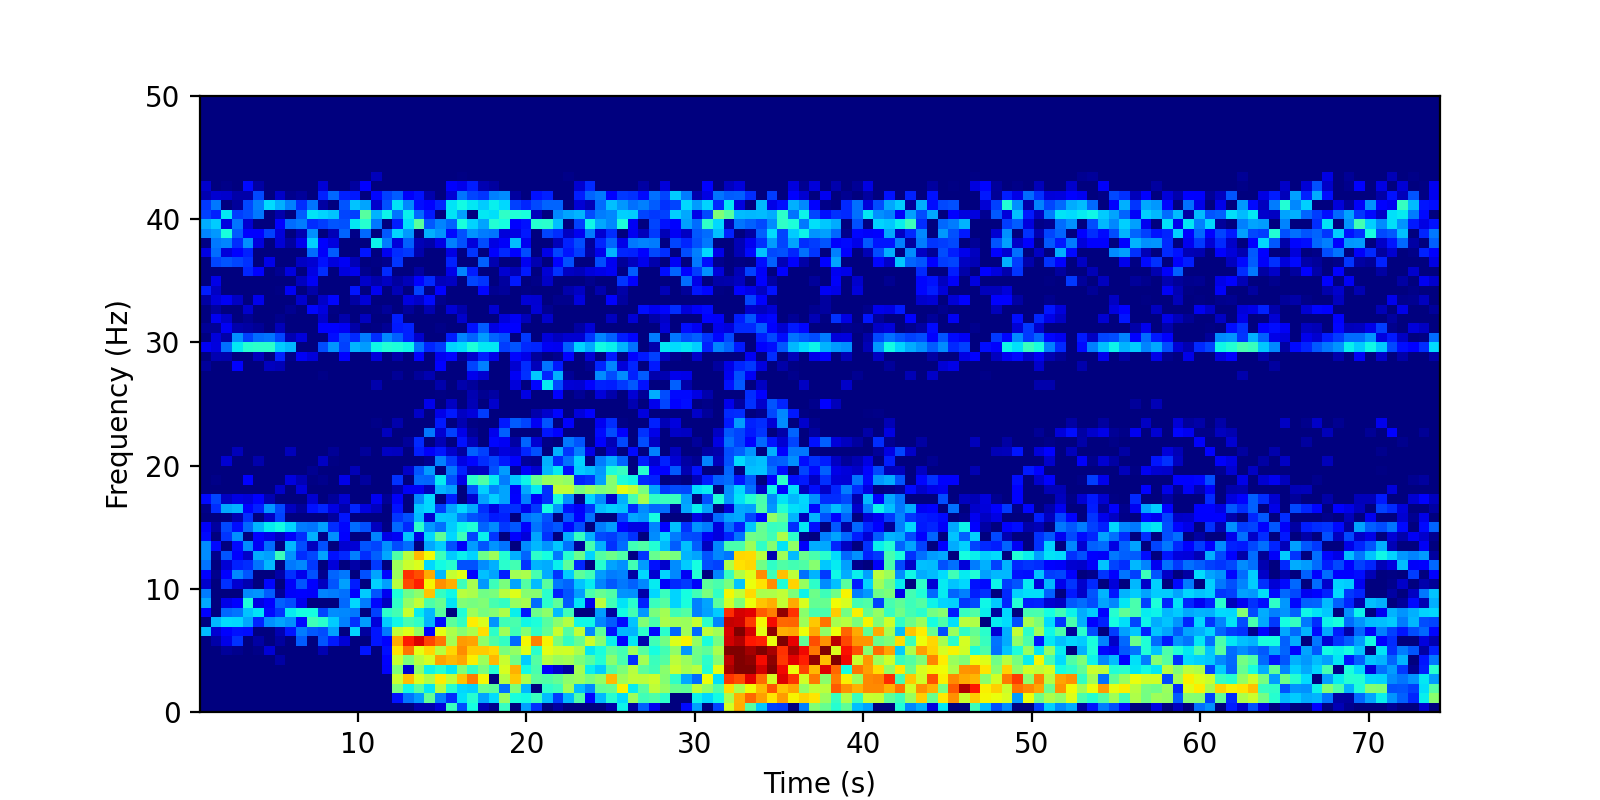

In [20]:
trace = data1[346,:]

f1, t1, Spg = signal.spectrogram(trace, 1./(dataz['dt'] * M), nperseg=128, noverlap=64)

plt.figure(figsize=[8,4])
clim = np.log10(Spg).max()/100
plt.imshow(np.log10(Spg), aspect='auto', cmap='jet', vmin=-7, vmax=-3, 
           origin='lower', extent=[t1[0], t1[-1], f1[0], f1[-1]])

plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

### Convert data to Obspy stream:

In [21]:
from obspy import Stream, Trace

st = Stream()

for i in range(data1.shape[1]):
    tr = Trace(data=data1[i,:], 
               header={'network': 'OC',
                       'station': 'DAS',
                       'channel': str(i),
                       'delta': dataz['dt'] * M, 
                       'starttime':datetime.datetime.strptime(str(dataz['event_time']), '%Y-%m-%d %H:%M:%S').timestamp()})
    st += tr

In [22]:
st[0].stats

         network: OC
         station: DAS
        location: 
         channel: 0
       starttime: 2016-03-20T23:37:30.000000Z
         endtime: 2016-03-20T23:38:44.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 7500
           calib: 1.0

<IPython.core.display.Javascript object>


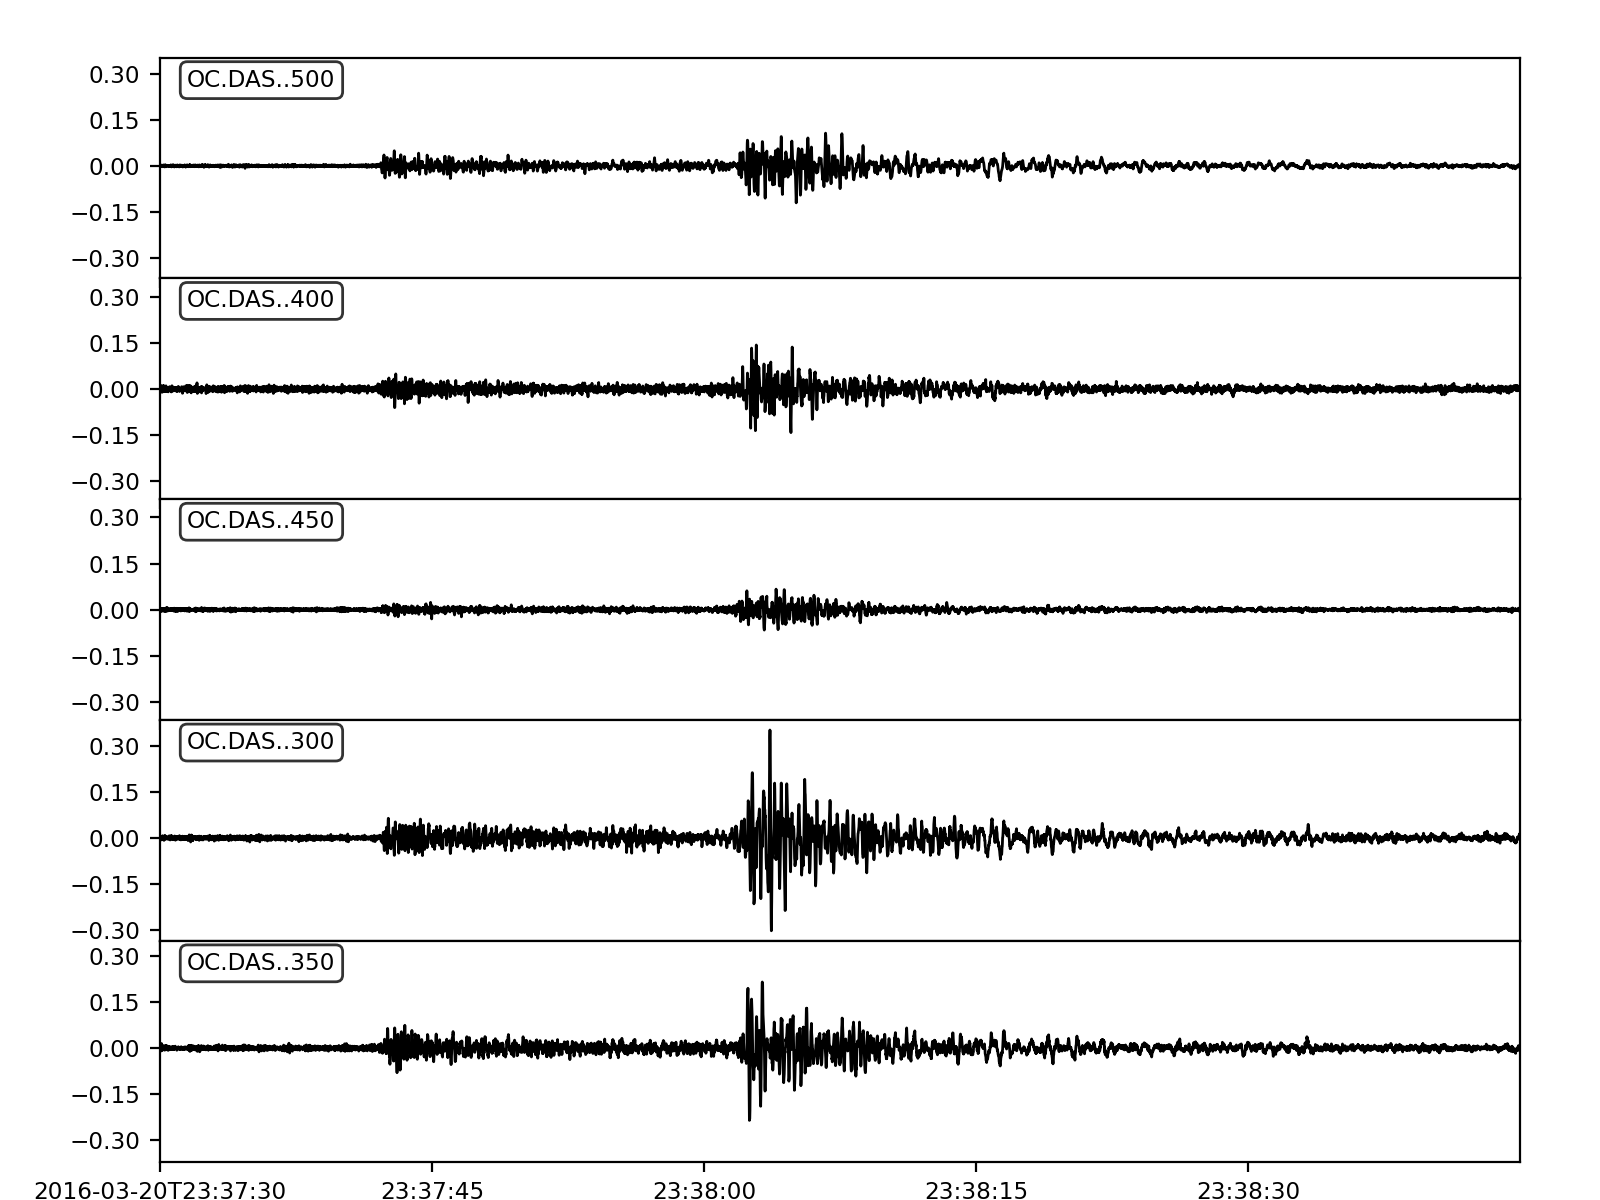

In [23]:
fig = plt.figure(figsize=[8,6])
st[300:501:50].plot(fig=fig)
plt.show()